# 参数配置

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

use_cuda = torch.cuda.is_available()

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# transforms
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       # transforms.RandomResizedCrop(224),
                                       # transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,], [0.5,])]) # mean, std
 

test_transforms = transforms.Compose([#transforms.Resize(255),
                                      #transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5,], [0.5,])]) # mean, std

federated_train_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/raoxy/data', train=True, download=True,
                   transform=train_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=True, **kwargs)


federated_test_loader = torch.utils.data.DataLoader( # <-- this is now a FederatedDataLoader 
    datasets.MNIST('/home/raoxy/data', train=False, download=True,
                   transform=test_transforms), # <-- NEW: we distribute the dataset across all the workers, it's now a FederatedDataset
    batch_size=200, shuffle=False, **kwargs)

# LeNet

In [20]:
import torch.nn as nn

flag="ALL"
# 定义重构后的 D_CNN 类
if flag=="D":
    class D_CNN(nn.Module):
        def __init__(self):
            super(D_CNN, self).__init__()
            # 添加一个卷积层，将输入数据的通道数从 1 增加到 32
            self.conv0 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # 修改第一个卷积层的高度和宽度为 3
            self.conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            # 添加一个池化层，将输入数据的高度和宽度减半
            self.pool0 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            # 保持第二个卷积层不变
            self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            # 保持第二个池化层不变
            self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            # 修改全连接层的输入维度为 64 * 8 * 7
            self.fc1 = nn.Linear(64 * 8 * 7, 1000)
            # 保持第二个全连接层不变
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            # 依次通过各个层，并使用 relu 激活函数
            x = self.conv0(x)
            x = nn.functional.relu(x)
            x = self.conv1(x)
            x = nn.functional.relu(x)
            x = self.pool0(x)
            x = self.conv2(x)
            x = nn.functional.relu(x)
            x = self.pool2(x)
            # 将张量展平为一维向量
            x = x.view(-1, 64 * 8 * 7)
            x = self.fc1(x)
            x = nn.functional.relu(x)
            x = self.fc2(x)
            # 使用 softmax 函数输出概率分布
            x = nn.functional.softmax(x, dim=1)
            return x
    model = D_CNN().to(device)
elif flag=="L":
    pass
else:
    class D_CNN(nn.Module):
        def __init__(self):
            super(D_CNN, self).__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
            self.fc1 = nn.Linear(64 * 7 * 7, 1000)
            self.fc2 = nn.Linear(1000, 10)

        def forward(self, x):
            x = self.conv1(x)
            x = nn.functional.relu(x)
            x = self.pool1(x)
            x = self.conv2(x)
            x = nn.functional.relu(x)
            x = self.pool2(x)
            x = x.view(-1, 64 * 7 * 7)
            x = self.fc1(x)
            x = nn.functional.relu(x)
            x = self.fc2(x)
            x = nn.functional.softmax(x, dim=1)
            return x
    model = D_CNN().to(device)
    
optimizer = optim.SGD(model.parameters(), lr=0.002,momentum=0.9) # TODO momentum is not supported at the moment
criterion = nn.CrossEntropyLoss().to(device)

# 训练

In [38]:
def compress_channel(data, k,flag="D",batch_size=200):
    if flag=="D":
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.numpy()
        output_D =  torch.empty(batch_size, 1,k, 28, dtype=torch.float, device="cpu").numpy()
        output_L = np.zeros_like(data)
        for i in range(len(data)):
            channel = data[i, 0, :, :]
            output_D[i, 0, :, :] = ksvd.fit(channel).components_
            L = ksvd.transform(channel)
    #         output_L[i, 0, :, :]  = np.clip(L, 0, 255)
        return torch.from_numpy(output_D)#torch.from_numpy(output_L)
    elif flag=="L":
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.numpy()
        output_D =  torch.empty(batch_size, 1,k, 28, dtype=torch.float, device="cpu").numpy()
        output_L = np.zeros_like(data)
        for i in range(len(data)):
            channel = data[i, 0, :, :]
            output_D[i, 0, :, :] = ksvd.fit(channel).components_
            output_L[i, 0, :, :]  = ksvd.transform(channel)
    #         output_L[i, 0, :, :]  = np.clip(L, 0, 255)
        return torch.from_numpy(output_L)#torch.from_numpy(output_L)
    else:
        from  ksvd import ApproximateKSVD
        ksvd = ApproximateKSVD(n_components=k)
        data = data.numpy()
        output_data =np.zeros_like(data)
        for i in range(len(data)):
            channel = data[i, 0, :, :]
            output_D = ksvd.fit(channel).components_
            output_L = ksvd.transform(channel)
            output_data[i, 0, :, :] =output_L.dot(output_D)
        return torch.from_numpy(output_data)

In [42]:
import numpy as np

loss_train=[]
acc_train=[]

def train(model, device, federated_train_loader, optimizer, epoch, batch_size):
    global criterion,txt,loss_train,acc_train
    model.train()
    train_loss = 0
    correct = 0
    n=0
    for batch_idx, (data, target) in enumerate(federated_train_loader): # <-- now it is a distributed dataset
        ##########################[KSVD分解]###############################
        target = target.to(device) 
        data=compress_channel(data, 32,"ALL")
        optimizer.zero_grad()
        output = model(data.to(device))
        ###########################[原始]##################################
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
        ################################################################
        n += target.shape[0]
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()
        pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss+=loss.item()

    train_loss /= len(federated_train_loader)
    loss_train.append(train_loss)
    acc_train.append(correct*1.0/ n)

    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    train_loss, correct, len(federated_train_loader) * batch_size,
     100.*correct / n))

loss_test=[]
acc_test=[]
def test(model, device, federated_test_loader, batch_size):
    global criterion,txt,loss_test,acc_test
    model.eval()
    test_loss = 0
    correct = 0
    n=0
    with torch.no_grad():
        for data, target in federated_test_loader:
#             model.send(data.location) # <-- NEW: send the model in virtual workers to Trusted Aggregator
            ##########################################################################
#             target = target.to(device) 
#             data=compress_channel(data, 28)
#             optimizer.zero_grad()
#             output = model(data.to(device))
            ##########################################################################
            data, target = data.to(device), target.to(device)
            output = model(data)
            #########################################################################
            n += target.shape[0]
            loss = criterion(output, target.long())
#             loss = F.nll_loss(output, target, reduction='sum')
#             model.get()
#             test_loss += loss.get() # sum up batch loss
            test_loss += loss.item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            # print("{}\t{}".format(correct,target.shape))

    test_loss /= len(federated_test_loader)
    loss_test.append(test_loss)
    acc_test.append(correct*1.0/n)

    print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(federated_test_loader) * batch_size,
        100. * correct / n))

In [43]:
for epoch in range(50):
    train(model, device, federated_train_loader, optimizer, epoch, batch_size=200)
    test(model, device, federated_test_loader, batch_size=200)

Train set: Average loss: 2.2194, Accuracy: 15754/60000 (26%)
	Test set: Average loss: 2.0416, Accuracy: 5262/10000 (53%)
Train set: Average loss: 1.8642, Accuracy: 39549/60000 (66%)
	Test set: Average loss: 1.7469, Accuracy: 7404/10000 (74%)
Train set: Average loss: 1.7410, Accuracy: 44257/60000 (74%)
	Test set: Average loss: 1.7126, Accuracy: 7571/10000 (76%)
Train set: Average loss: 1.7208, Accuracy: 44945/60000 (75%)
	Test set: Average loss: 1.7020, Accuracy: 7643/10000 (76%)
Train set: Average loss: 1.7100, Accuracy: 45411/60000 (76%)
	Test set: Average loss: 1.6596, Accuracy: 8231/10000 (82%)
Train set: Average loss: 1.6478, Accuracy: 49798/60000 (83%)
	Test set: Average loss: 1.6178, Accuracy: 8516/10000 (85%)
Train set: Average loss: 1.6316, Accuracy: 50385/60000 (84%)
	Test set: Average loss: 1.6075, Accuracy: 8594/10000 (86%)
Train set: Average loss: 1.6227, Accuracy: 50814/60000 (85%)
	Test set: Average loss: 1.6027, Accuracy: 8625/10000 (86%)
Train set: Average loss: 1.6162,

# 结果保存

In [ ]:
# save_name='LeNet-no-fed-cifar100'

In [ ]:
# 保存模型的权重
# torch.save(model.state_dict(), "/home/raoxy/model/out/{}.pt".format(save_name))
# print("保存文件：","/home/raoxy/model/out/{}.pt".format(save_name))

In [ ]:
# # 保存整个模型
# torch.save(model, "/home/raoxy/model/out/{}.h5".format(save_name))
# print("保存文件：","/home/raoxy/model/out/{}.h5".format(save_name))

# 分析

In [44]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
mpl.use('nbAgg')

In [47]:
import pandas as pd
df=pd.DataFrame([loss_train, loss_test, acc_train, acc_test]).T
df.columns =['loss_train', 'loss_test','acc_train','acc_test']
# df.to_csv("/home/raoxy/file/{}".format(save_name),index=False)
mpl.style.use('seaborn-white')

<IPython.core.display.Javascript object>


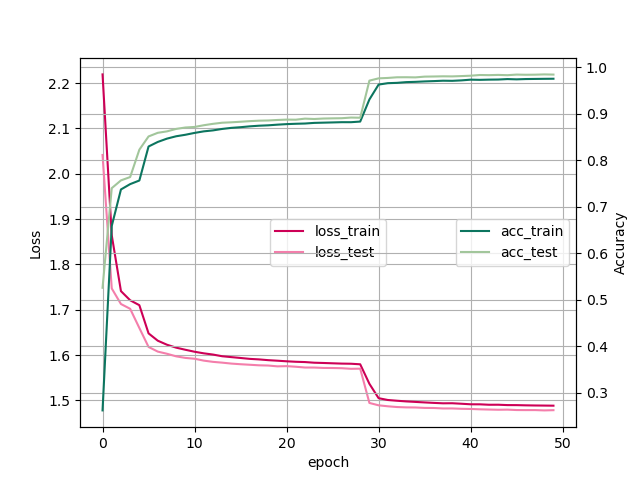

In [46]:
# 将DataFrame中的数据进行可视化，设置两个y轴
ax = df[['loss_train', 'loss_test']].plot(color=['#CD0056','#F47EAB'])
# 创建一个新的Axes对象，共享x轴
ax2 = ax.twinx()
# 绘制'acc_train'和'acc_test'在右侧y轴
df[['acc_train', 'acc_test']].plot(ax=ax2, color=['#0C755F', '#A2C69B'])
# 设置左侧y轴标签
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')
# 设置右侧y轴标签
ax2.set_ylabel('Accuracy')
ax.grid(True)
ax2.grid(True)
ax.legend(loc='center')
ax2.legend(loc='center right')
# 显示图形
plt.show()